In [1]:
"""Header cell, contains modules and functions to make the whole notebook experience better"""
%matplotlib inline 
# plots graphs within the notebook

from IPython.display import display,Image, Latex
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
from IPython.display import clear_output

import time

from IPython.display import display,Image, Latex

from IPython.display import clear_output


import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc


import sympy as sym

    
font = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }
fontlabel = {'family' : 'serif',
        #'color'  : 'black',
        'weight' : 'normal',
        'size'   : 12,
        }

from matplotlib.ticker import FormatStrFormatter
plt.rc('font', **font)

class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    

In [2]:
PDF('bot-sketch.pdf',size = (550,400))

# Differential Drive Robot - 1

Alphabot 2 is a differential drive robot: Two independent motors drive the left and right wheels and the differential speed between the two wheels control the speed and direction of the robot. The following code is copied from http://enesbot.me/kinematic-model-of-a-differential-drive-robot.html

## Objective
This notebook focuses on the control of a simulated differential drive robot for prescribed simple tasks. 

## Theoretical Background

The robot parameters are:
<ul>
    <li> Wheel radius: $r$. </li>
    <li> Length between wheels: $L$ </li>
    <li> Angular velocity of the left and right wheels: $\omega_L$, $\omega_R$, respectively.</li>
    <li> Angle from horizontal: $\alpha$.</li>
    <li> Position vector of the robot: $(x,y)$.</li>
    <li> Velocity vector of the robot: $V=(\dot{x},\dot{y})$.</li>
</ul>
Hereafter $\dot{a}$ refers to the time derivative of variable $a$:

$$
\dot{a}=\frac{da}{dt}
$$

The velocities of the wheels are therefore defined as:

$$
V_L=\omega_Lr\text{ and }V_R=\omega_Rr.
$$

The velocity of the robot, taken at the center of the wheels, is simply:

$$
\vec{V}=\frac{V_R+V_L}{2}(\cos(\alpha)\vec{e}_x+\sin(\alpha\vec{e}_y),
$$

yielding the following equations of motions:

$$
\dot{x}=r\frac{\omega_R+\omega_L}{2}\cos{\alpha}
$$

$$
\dot{y}=r\frac{\omega_R+\omega_L}{2}\sin{\alpha}
$$

and

$$
\dot{\alpha}=\frac{r}{L}(\omega_R-\omega_L)
$$

Numerically, these solutions of these equations requires their <b>discretization</b>. Remember that the derivative $da/dt$ of a variable $a=f(t)$ is the slope $s$ of the local tangent. Over a small enough time interval $\Delta t$, any continuous function $f$ can be approximated by a linear function based on the slope $a(t+\Delta t$)=a(t)+s(t)\Delta t$. The derivative is then estimated as:

$$
\frac{da}{dt}\approx\frac{\Delta a}{\Delta t}
$$

where $\Delta a=a(t+\Delta t$)-a(t)$. The discretized equations of motion may be recast as an integration of the trajectory of the robot:

$$
x(t+\Delta t) = x(t) +\Delta t\left(r\frac{\omega_R+\omega_L}{2}\cos{\alpha}\right),
$$

$$
y(t+\Delta t) = y(t) +\Delta t\left(r\frac{\omega_R+\omega_L}{2}\sin{\alpha}\right),
$$

$$
\alpha(t+\Delta t) = \alpha(t) +\Delta t\left(r\frac{\omega_R-\omega_L}{L}\right).
$$

As long as, the <b>initial conditions</b> are prescribed at $t=0$, the motion of the robot is predictable providing that $\Delta t$ is not too large, as we shall see later. The present discretization is the simplest one, and also the most rudimentary. Even though the above equations carry fairly large numerical errors, no robot is perfect and these numerical errors will not be discussed here.

## Code description

The code below defines a class, named Robot, which includes the robot dimensions, position variables ($x,y,\alpha$), the time step $\Delta t$, the left/right angular velocities and various functions necessary to integrate the robot motion. First execute the cell below.


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.constants as sc


import sympy as sym


from math import sin, cos

class Robot(object):
    """Defines basic mobile robot properties"""
    def __init__(self):
        self.pos_x  = 0.0
        self.pos_y  = 0.0
        self.angle  = 0.0
        self.plot   = False
        self._delta = 0.01
        self.step_plot = int(5)
        self.mag_plot = 1.

    # Movement
    def step(self):
        """ updates the x,y and angle """
        self.deltax()
        self.deltay()
        self.deltaa()

    def move(self, seconds):
        """ Moves the robot for an 's' amount of seconds"""
        for i in range(int(seconds/self._delta)):
            self.step()
            if i % self.step_plot == 0 and self.plot: # plot path every 3 steps
                self.plot_xya()

    # Printing-and-plotting:
    def print_xya(self):
        """ prints the x,y position and angle """
        print ("x = " + str(self.pos_x) +" "+ "y = " + str(self.pos_y))
        print ("a = " + str(self.angle))

    def plot_robot(self):
        """ plots a representation of the robot """
        plt.arrow(self.pos_x, self.pos_y, 0.001
                  * cos(self.angle), 0.001 * sin(self.angle),
                  head_width=self.mag_plot*self.length, head_length=self.mag_plot*self.length,
                  fc='k', ec='k')

    def plot_xya(self):
        """ plots a dot in the position of the robot """
        plt.scatter(self.pos_x, self.pos_y, c='r', edgecolors='r')


class DDRobot(Robot):
    """Defines a differential drive robot"""

    def __init__(self):
        Robot.__init__(self)
        self.radius = 0.1
        self.length = 0.4

        self.rt_spd_left = 0.0
        self.rt_spd_right = 0.0

    def deltax(self):
        """ update x depending on l and r angular speeds """
        self.pos_x += self._delta * (self.radius*0.5) \
        * (self.rt_spd_right + self.rt_spd_left)*cos(self.angle)

    def deltay(self):
        """ update y depending on l and r angular speeds """
        self.pos_y += self._delta * (self.radius*0.5) \
        * (self.rt_spd_right + self.rt_spd_left)*sin(self.angle)

    def deltaa(self):
        """ update z depending on l and r angular speeds """
        self.angle += self._delta * (self.radius/self.length) \
        * (self.rt_spd_right - self.rt_spd_left)
# function to convert degrees to radians
def D2R(a):
    return math.pi*a/180
def R2D(a):
    return 180*a/math.pi
# mybot = DDRobot()            # robot called 'enesbot'

# mybot.angle = 3.1416/4        # 45 degrees
# mybot.plot = True             # plot the robot!
# mybot.plot_robot()

# mybot.rt_spd_left = 10
# mybot.rt_spd_right = 10       # straight line
# mybot.move(2)                 # move for 2 seconds

# mybot.rt_spd_left = 12.5664
# mybot.rt_spd_right = 18.8496  # (2m diameter circle)
# mybot.move(1)                 # move for 1 second

# mybot.rt_spd_left = 18.8496
# mybot.rt_spd_right = 12.5664  # (2m diameter circle)
# mybot.move(2.5)               # move for 2.5 second

# mybot.rt_spd_left = 12.5664
# mybot.rt_spd_right = 18.8496  # (2m diameter circle)
# mybot.move(3.5)               # move for 2.5 second

# mybot.plot_robot()

# plt.xlim([-1, 6])               # axis limits
# plt.ylim([-1, 6])

# plt.show()

## Quick Tutorial

Now you can create your first robot.

In [4]:
mybot = DDRobot()

For simplicity, assume that all units are based on the metric system. Your new robot, <FONT FACE="courier" style="color:blue">mybot</FONT>, is by default located at $(x=0,y=0)$, its angle from the horizontal axis $x$ is $0$ and the wheel radius and length between wheel are $r=0.1$m and $L=0.4$m (see class <FONT FACE="courier" style="color:blue">DDRobot</FONT>). The default time step is $\Delta t=0.01$s. All these variables and more can be easily customized to your problem:

In [5]:
mybot.pos_x = 0 #x
mybot.pos_y = 0 #y
mybot.angle = D2R(45) #alpha
mybot.length =0.4 #L
mybot.radius = 0.1 #r
mybot.rt_spd_left = 10 # omega_L
mybot.rt_spd_right = 10 # omega_R


Now that our initial conditions and rotational speed is set, let's move our robot in a straight line and plot its trajectory.

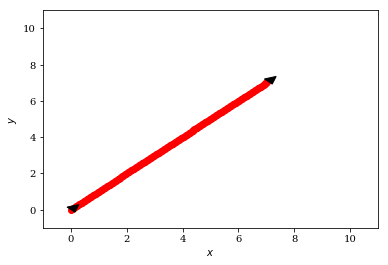

In [6]:
mybot.plot = True #True if you want to plot the robot's trajectory
mybot.plot_robot() #draw an arrow for the location of the robot at t=0

mybot.move(10) #move the robot for 10s
mybot.plot_robot() #draw the new location

plt.xlim(-1,11)
plt.ylim(-1,11)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

You may change the size of the arrow and the spacing of the dots making the trajectory using the following variables:

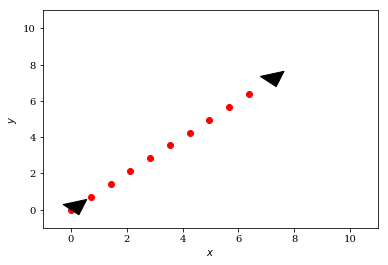

In [7]:
mybot.mag_plot = 2 #coefficient of magnification of the arrow
mybot.step_plot = 100 # plot location every 100 iterations

mybot.pos_x = 0 #x
mybot.pos_y = 0 #y
mybot.angle = D2R(45) #alpha
mybot.length =0.4 #L
mybot.radius = 0.1 #r
mybot.rt_spd_left = 10 # omega_L
mybot.rt_spd_right = 10 # omega_R


mybot.plot = True #True if you want to plot the robot's trajectory
mybot.plot_robot() #draw an arrow for the location of the robot at t=0

mybot.move(10) #move the robot for 10s
mybot.plot_robot() #draw the new location

plt.xlim(-1,11)
plt.ylim(-1,11)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

You may print the location of your robot using:

In [8]:
mybot.print_xya()

x = 7.071067811865343 y = 7.071067811865343
a = 0.7853981633974483


which you can compare to the theoretical location of the robot. Since the robot's wheel radius is $0.1$m, the rotational speed is $\omega=10$ (1/s), therefore the robot speed is $1$m/s. Over $10$s of travel time, starting at an angle of $45^\circ$, the location of the robot should be $x=10\cos(\pi/4)$ and $y=10\sin(\pi/4)$.

In [9]:
print('absolute error x: %1.1e m' %(abs(mybot.pos_x - 10*math.cos(math.pi/4))))
print('absolute error y: %1.1e m' %(abs(mybot.pos_y - 10*math.sin(math.pi/4))))
print('absolute error alpha: %1.1e rad' %(abs(mybot.angle - math.pi/4)))

absolute error x: 1.3e-13 m
absolute error y: 1.3e-13 m
absolute error alpha: 0.0e+00 rad


To turn, the left and right angular velocities must be different, as shown below

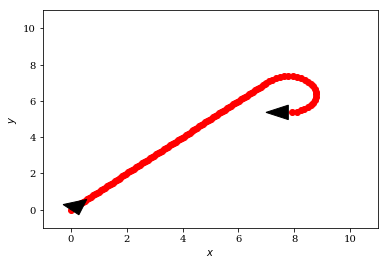

In [10]:

mybot.mag_plot = 2 #coefficient of magnification of the arrow
mybot.step_plot = 10 # plot location every 100 iterations

mybot.pos_x = 0 #x
mybot.pos_y = 0 #y
mybot.angle = D2R(45) #alpha
mybot.length =0.4 #L
mybot.radius = 0.1 #r


mybot.plot = True #True if you want to plot the robot's trajectory
mybot.plot_robot() #draw an arrow for the location of the robot at t=0

# move straight for 10m
mybot.rt_spd_left = 10 # omega_L
mybot.rt_spd_right = 10 # omega_R
mybot.move(10) #move the robot for 10s

# 2m radius turn
mybot.rt_spd_left = 18.8496
mybot.rt_spd_right = 12.5664
mybot.move(2.5) 

mybot.plot_robot() #draw the new location

plt.xlim(-1,11)
plt.ylim(-1,11)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## Assignment

### 1 Iterative turn
In this first assignment the robot must start at $(0,0)$, drive horizontally to $(10,0)$, then vertically to $(10,10)$, horizontally to $0,10$ and finally vertically to $(0,0)$. Write a code using a for loop to move your robot. Within the for loop, turn your robot using a while loop. Use the same robot dimensions as above and an absolute angular velocity $\omega = 10$.

0
2.864788975654116
5.729577951308232
8.59436692696235
11.459155902616464
14.32394487827058
17.188733853924695
20.05352282957881
22.91831180523293
25.78310078088704
28.647889756541158
31.512678732195273
34.37746770784939
37.24225668350351
40.10704565915763
42.97183463481175
45.83662361046587
48.701412586119986
51.56620156177411
54.43099053742822
57.29577951308233
60.16056848873646
63.025357464390574
65.89014644004469
68.75493541569881
71.61972439135293
74.48451336700705
77.34930234266116
80.21409131831528
83.0788802939694
85.94366926962353
88.80845824527763
91.67324722093176
1
2.8647889756541183
5.7295779513082365
8.594366926962357
11.459155902616473
14.323944878270595
17.188733853924713
20.05352282957883
22.91831180523294
25.78310078088704
28.647889756541147
31.512678732195255
34.37746770784936
37.24225668350346
40.10704565915757
42.97183463481168
45.836623610465786
48.70141258611989
51.566201561774
54.4309905374281
57.2957795130822
60.16056848873631
63.02535746439042
65.8901464400445

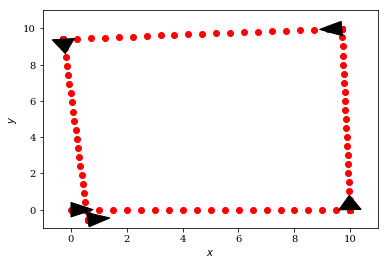

In [11]:
mybot = DDRobot()            # robot called 'enesbot'
mybot.mag_plot = 2 #coefficient of magnification of the arrow
mybot.step_plot = 50 # plot location every 100 iterations

mybot.pos_x = 0 #x
mybot.pos_y = 0 #y
mybot.angle = 0 #alpha
mybot.length =0.4 #L
mybot.radius = 0.1 #r
omega = 10
rot_time_increment = 0.01 #time increment for rotation
rotation_angle = D2R(90)

mybot.plot = True #True if you want to plot the robot's trajectory
mybot.plot_robot() #draw an arrow for the location of the robot at t=0

for i in range(4):
    print(i)
    # move straight for 10m
    mybot.rt_spd_left = omega # omega_L
    mybot.rt_spd_right = omega # omega_R
    mybot.move(10) #move the robot for 10s
    # turn 90 degrees to the left
    mybot.rt_spd_left = -omega # omega_L
    mybot.rt_spd_right = omega # omega_R
    alpha_0 = mybot.angle
    while (mybot.angle - alpha_0) < rotation_angle:
        mybot.move(rot_time_increment)
        print(R2D(mybot.angle - alpha_0))
        
    mybot.plot_robot() #draw the new location

plt.xlim(-1,11)
plt.ylim(-1,11)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()



As you can see, the robot does not return to its origin. Quantify the error.

In [45]:
print('absolute error x: %1.1e m' %(math.sqrt(mybot.pos_x**2 +mybot.pos_y**2)))

absolute error x: 8.1e-01 m


### 2 Exact rotation

Derive and implement an equation to determine the exact time needed for the robot to achieve a rotation of a given angle around its center. Quantify the error

In [ ]:
# your code here

### 3 Circular motion

Derive and implement an equation to determine the paramters (angular velocities and motion time) needed for the robot to achieve an arc of a given radius and angle (from origin to end).

In [ ]:
# your code here